# Vision Transformers

**See and Tell** strives to provided as detailed a description of the image as possible. To achieve this, we heavily exploited vision transformers - an architecture  that has been shown to be very effective in computer vision tasks. The particular choice of GIT  model enables us to describe any scenes without any fine-tuning. 

## Attention

As any transformer-based architecture, the GIT model is built on the concept of attention. The attention mechanism allows the model to focus on the most important parts of the image. So far, we have not used attention directly, but we see a way for it to be used to enhance the quality of matching between words in the caption and a character in the image. *This notebook contains a research about usability of attention in the context of See and Tell.*

## GIT 

The GIT model, described in , generates text from the image using the following architecture:

<div align="center">
<img src="figures/git-0.png", width="60%">
</div>

The image is processed as a sequence of embedded patches , which are then fed into a transformer encoder. The embedding of each patch is provided using CLIP  model, which is also used to embed text into the same space and append it to the sequence of patches. The transformer encoder then outputs a sequence of vectors, which are then fed into a transformer decoder. The decoder is trained to predict the next word in the caption given the previous words and the image. The model utilizes specific attention mask in the decoder, which prevents the model from attending to the future words in the caption, but allows any text token to attend to any image patch. 

<div align="center">
<img src="figures/git-1.png", width="30%">
</div>


## Extracting Attentions

We are particularly interested in the attention weights between the image patches and the text tokens. We hypothesize that the attention weights can be used to match the words in the caption to the characters in the image. To extract the attention weights, we use the following procedure:

1. We feed the image and the caption into the GIT model and obtain the attention weights between the image patches and the text tokens. Weights are extracted from the each layer and each head of the decoder. The weights are averaged across layers and heads to obtain a single attention matrix.
2. Initially, attention weights correspond to patch tokens rather than image pixels. To obtain the attention weights w.r.t image we upscale weights.
3. The IoU between face bounding boxes and upscaled attention weights is computed. The bounding boxes are obtained using the face detector from . The bounding boxes are then used to obtain the attention weights between the image patches and the face bounding boxes.

<div align="center">------------ THE CODE STARTS HERE ------------</div>

We are using GIT provided with Hugging Face . This implementation provides a convenient way to extract attention weights from the model.

In [1]:
# %pip install torch maltplotlib numpy

import os
import torch
import matplotlib.pyplot as plt
from transformers import GitForCausalLM, GitProcessor, GitConfig, GitVisionConfig
from PIL import Image
from pydantic import BaseModel, ConfigDict

In [2]:
MODEL = 'microsoft/git-large-r-textcaps'

In [3]:
processor = GitProcessor.from_pretrained(MODEL)
git_model = GitForCausalLM.from_pretrained(MODEL)
config = GitConfig.from_pretrained(MODEL)
vision_config = GitVisionConfig.from_pretrained(MODEL)

Extracting important contants from the model:

1. Patch size is a size of small parts of the image, which are processed by the vision encoder.
2. Image size is a size of the image, which is processed by the vision encoder.
3. Number of heads is a number of attention heads in the decoder.
4. Number of layers is a number of layers in the decoder.

In [4]:
patch_size = vision_config.patch_size
num_heads = config.num_attention_heads
num_layers = config.num_hidden_layers
image_size = vision_config.image_size
num_tokens = 2 + (image_size // patch_size) ** 2
num_patches = (image_size // patch_size) ** 2

print("Patch size:\t\t", patch_size)
print("Image size:\t\t", image_size)
print("Number of heads:\t", num_heads)
print("Number of layers:\t", num_layers)
print("Number of tokens:\t", num_tokens)
print("Number of patches:\t", num_patches)

Patch size:		 14
Image size:		 224
Number of heads:	 12
Number of layers:	 6
Number of tokens:	 258
Number of patches:	 256


The following code contains three important functions:

1. `upscale_attention_weights` upscales attention weights from the patch tokens to the image pixels. So, given the attention weights between the patch tokens and the text tokens of size `(2 + number_of_patches, 2 + number_of_patches)`, it returns the attention weights between the image pixels and the text token of size `(image_size, image_size)`. The `+2` thing comes from the fact that on each generation step there is only one text token, and an additional `CLS` token which is not taken into account. 
2. `average_attention_weights` averages attention weights across layers and heads. So, given the attention weights of size `(number_of_layers, number_of_heads, 2 + number_of_patches, 2 + number_of_patches)`, it returns the attention weights of size `(2 + number_of_patches, 2 + number_of_patches)`.
3. `caption_image_files` is a function that returns a list of image files and captions.

To obtain attentions they are firstly averaged, then a сertain slice of the attention weights matrix is retrieved, transformed and upscaled.

In [23]:
class CaptionOutput(BaseModel):
    """Stores the output of captioning an image."""

    image_paths: list[str]
    caption_tokens: list[list[str]]
    caption_text: list[str]
    attention_masks: list[torch.Tensor]

    model_config: ConfigDict = ConfigDict(
        # Allow tensors
        arbitrary_types_allowed=True
    )


def upscale_attention_weights(
    mask: torch.Tensor,
    patch_size: int = patch_size,
    image_size: int = image_size,
) -> torch.Tensor:
    """Upscales a patch-level attention weights to an image-level attention weights."""
    
    assert (
        mask.shape[-1] == (image_size // patch_size) ** 2
    ), f"{mask.shape[-1]} != {(image_size // patch_size) ** 2}"
    output = torch.zeros(image_size, image_size)

    num_patches = image_size // patch_size
    for i in range(image_size // patch_size):
        for j in range(image_size // patch_size):
            # output[i:(i + patch_size), j:(j + patch_size)] = mask[i // num_patches, j % num_patches]
            output[
                i * patch_size : (i + 1) * patch_size,
                j * patch_size : (j + 1) * patch_size,
            ] = mask[i * num_patches + j]

    return output


def average_attention_weights(
    attention_masks: tuple[tuple[torch.Tensor]],
    patch_size: int = patch_size,
    image_size: int = image_size,
    num_heads: int = num_heads,
    num_layers: int = num_layers,
) -> torch.Tensor:
    """Averages the attention masks across all heads and layers."""

    assert len(attention_masks) == num_layers, f"{len(attention_masks)} != {num_layers}"
    assert (
        attention_masks[0].shape[1] == num_heads
    ), f"{len(attention_masks[0][1])} != {num_heads}"

    num_tokens = 2 + (image_size // patch_size) ** 2
    attention = torch.zeros(num_tokens, num_tokens)
    for layer in range(num_layers):
        interattention = torch.zeros(num_tokens, num_tokens)
        for head in range(num_heads):
            interattention += attention_masks[layer][0][head][:num_tokens, :num_tokens]

        attention += interattention / num_heads
    attention /= num_layers

    return attention


def caption_image_files(
    image_paths: os.PathLike | list[os.PathLike],
    model: GitForCausalLM | str = "microsoft/git-large-r-textcaps",
    processor: GitProcessor | None = processor,
    batch_size: int = 1,
) -> CaptionOutput:
    """Generates captions for a list of image files."""

    if isinstance(model, str):
        model = GitForCausalLM.from_pretrained(model)

    if processor is None:
        processor = GitProcessor.from_pretrained(model)

    if not isinstance(image_paths, list):
        image_paths = [image_paths]

    outputs = CaptionOutput(
        caption_tokens=[],
        caption_text=[],
        attention_masks=[],
        image_paths=[],
    )

    for i in range(0, len(image_paths), batch_size):
        batch_paths = image_paths[i : i + batch_size]
        batch = [Image.open(path).convert("RGB") for path in batch_paths]

        inputs = processor(images=batch, return_tensors="pt")
        outputs_ = model.generate(
            pixel_values=inputs["pixel_values"],
            output_attentions=True,
            output_hidden_states=True,
            return_dict_in_generate=True,
        )

        outputs.caption_tokens.extend(outputs_.sequences.tolist())
        outputs.caption_text.extend(processor.batch_decode(outputs_.sequences.tolist()))
        outputs.attention_masks.extend(outputs_.attentions)
        outputs.image_paths.extend(batch_paths)

    return outputs

## Experiment

The experiment will consist of assesing the descriptive power of the attention weights. We will use the following procedure: 

1. We will extract the attention weights between the image patches and the text tokens.
2. We will upscale the attention weights to obtain the attention weights between the image pixels and the text tokens.
3. We will plot the upscaled weigths as an overlay on the image. The highlighted parts of the image will correspond to the most important parts of the image for the given text token. We wish to see a reasonable match between the faces in the image and words like man or woman

In [14]:
outputs = caption_image_files("./misc/attention/frame.jpg")

/home/teexone/miniconda3/envs/uni/lib/python3.10/site-packages/transformers/generation/utils.py:1260: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


['[CLS] a woman is hugging a man on a couch with a book shelf behind them. [SEP]']

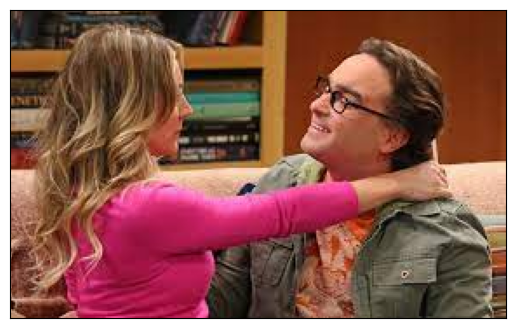

In [15]:
plt.xticks([])
plt.yticks([])
plt.imshow(Image.open('./misc/attention/frame.jpg'))
outputs.caption_text

In [16]:
words = processor.tokenizer.convert_ids_to_tokens(outputs.caption_tokens[0])[:-1]

In [17]:
def plot_ax(
    image: torch.Tensor, attention: torch.Tensor, word: str, ax=None
):
    ax.imshow(image, aspect='auto')
    ax.imshow(attention, cmap='gray', alpha=0.7, aspect='equal')
    ax.set_title(word, fontsize=5)
    ax.set_xticks([])
    ax.set_yticks([])


Let us firstly produce highlights for the average attention weights across layers and heads.

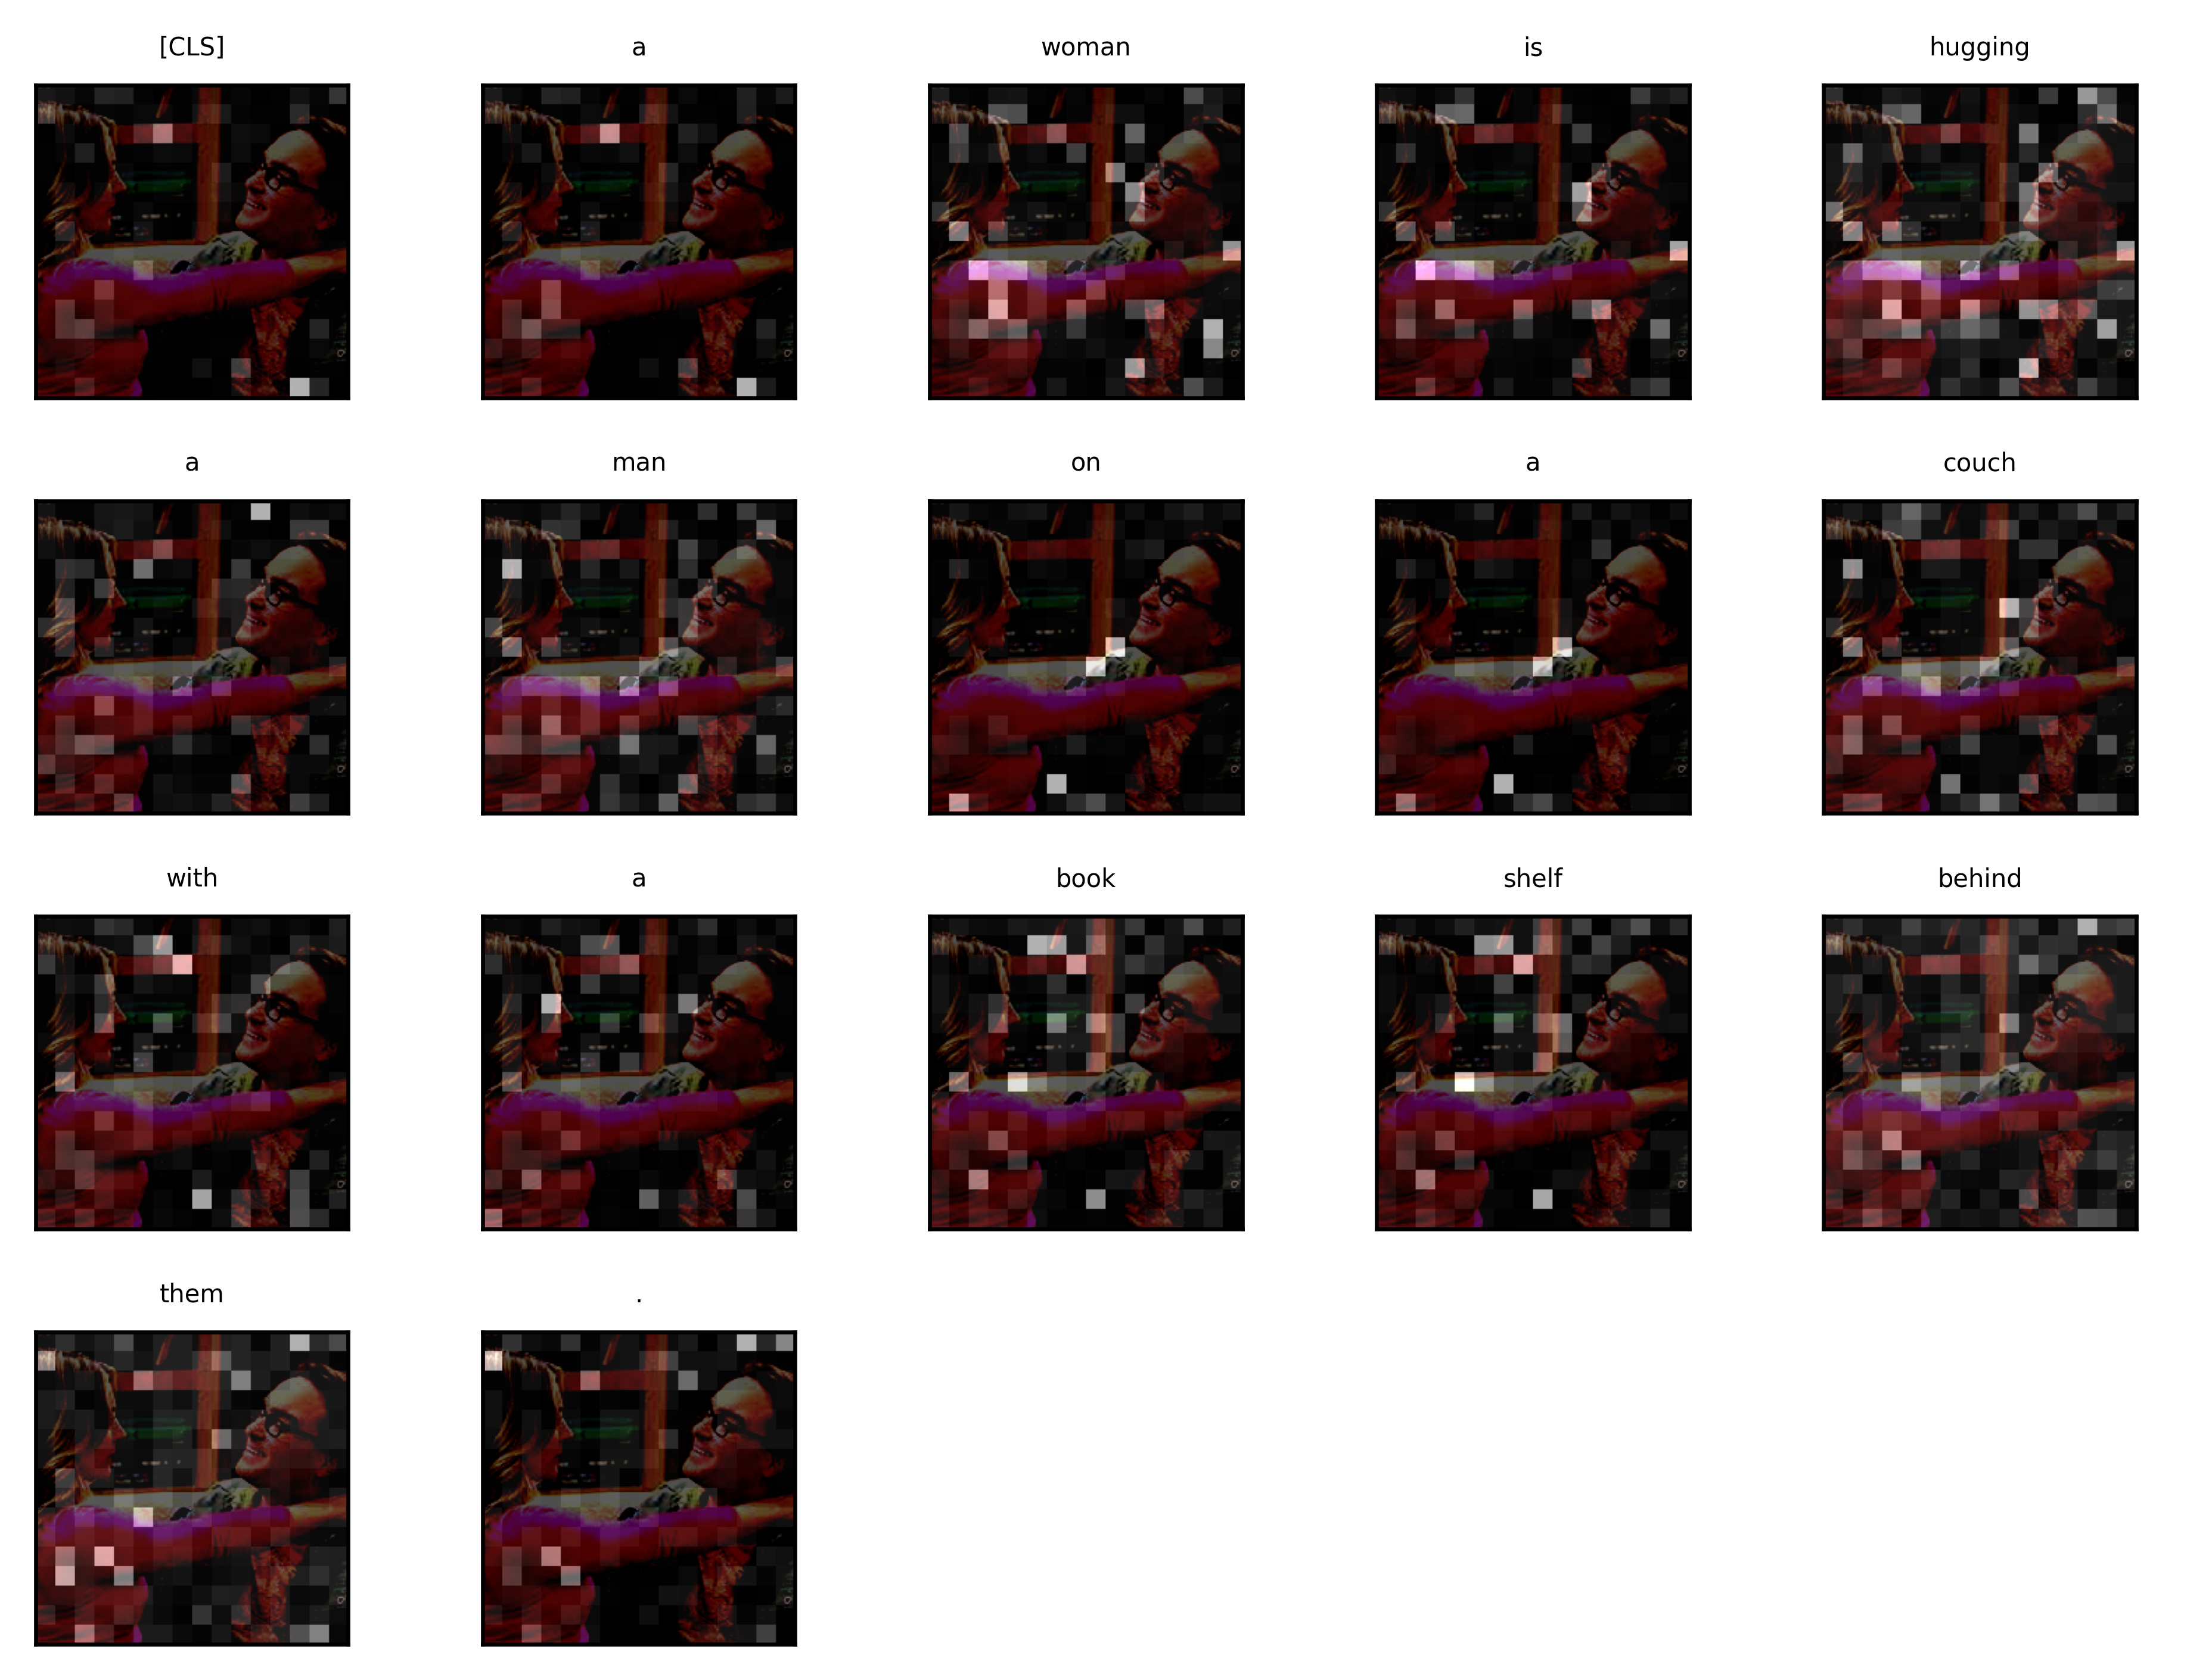

In [24]:
nrows, ncols = (len(words) + 4) // 5, 5

fig, axs = plt.subplots(nrows, ncols, dpi=600)
image = processor(images=[Image.open('./misc/attention/frame.jpg').convert('RGB')], return_tensors='pt')
image = image['pixel_values'][0].permute(1, 2, 0).numpy().clip(0, 1)
for i, word in enumerate(words):
    average_attention = average_attention_weights(outputs.attention_masks[i])
    upscaled_attention = upscale_attention_weights(average_attention[-1, :num_patches])
    plot_ax(image, upscaled_attention, word, ax=axs[i // ncols, i % ncols])
    
for i in range(len(words), nrows * ncols):
    axs[i // ncols, i % ncols].axis('off')

plt.xticks([])
plt.yticks([])
plt.tight_layout()
plt.savefig('./misc/attention/average_attention.png', dpi=600)
plt.show()


### Conclusion For Average Attention Weights

The following images show the attention weights for the average attention weights across layers and heads. It is visible that for words 'man' and 'woman' the highlighted parts does not give promising results. The highlighted parts are not the faces of the people, but rather the background or any other part of the image. 

## Layer Attention

Let us focus on particular words and average attention not across the whole system, but rather within layers

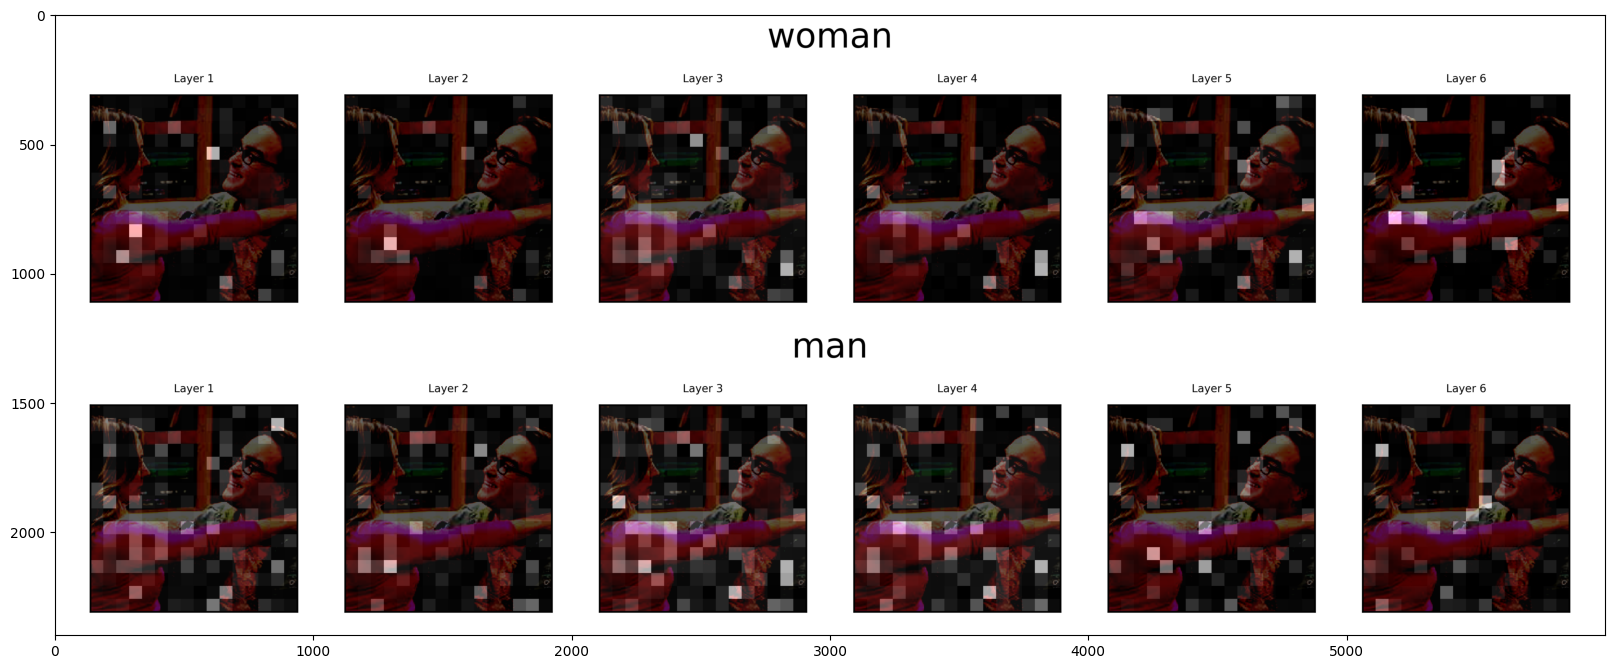

In [28]:
import numpy as np

word_ids = [(i, word,) for i, word in enumerate(words) if word in ['man', 'woman']]
pictures = []
for i, word in word_ids:
    fig, axs = plt.subplots(1, num_layers , dpi=600, figsize=(10, 2))
    
    for layer in range(num_layers):
        average_attention = outputs.attention_masks[i][layer].mean(dim=1)[0]
        upscaled_attention = upscale_attention_weights(average_attention[-1, :num_patches])
        plot_ax(image, upscaled_attention, f'Layer {layer + 1}', ax=axs[layer])
    
    fig.suptitle(word, fontsize=16)
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
    plt.savefig(f'./misc/attention/layer_{word}_{i}_attention.png', dpi=600)
    plt.close()
    
    pictures.append(Image.open(f'./misc/attention/layer_{word}_{i}_attention.png').convert('RGB'))
    
plt.xticks([])
plt.yticks([])
joined = np.vstack([np.array(p) for p in pictures])
plt.imsave('./misc/attention/layer_attention.png', joined)
plt.close()
fig = plt.figure(figsize=(20, 10))
plt.imshow(Image.open('./misc/attention/layer_attention.png').convert('RGB'))

### Conclusion For Layer Attention

Averaging attention weights across layers provides better results. The pattern is visible but not very strong. The attended parts are still appear to be the background and has a little relation to the faces or bodies of the people.

## Head Attention

The last attempt is to average attention weights across heads. This is the most granular approach, which allows us to see the most detailed attention weights for each word as not averaging will probably lead to a plot that is impossible to interpret.

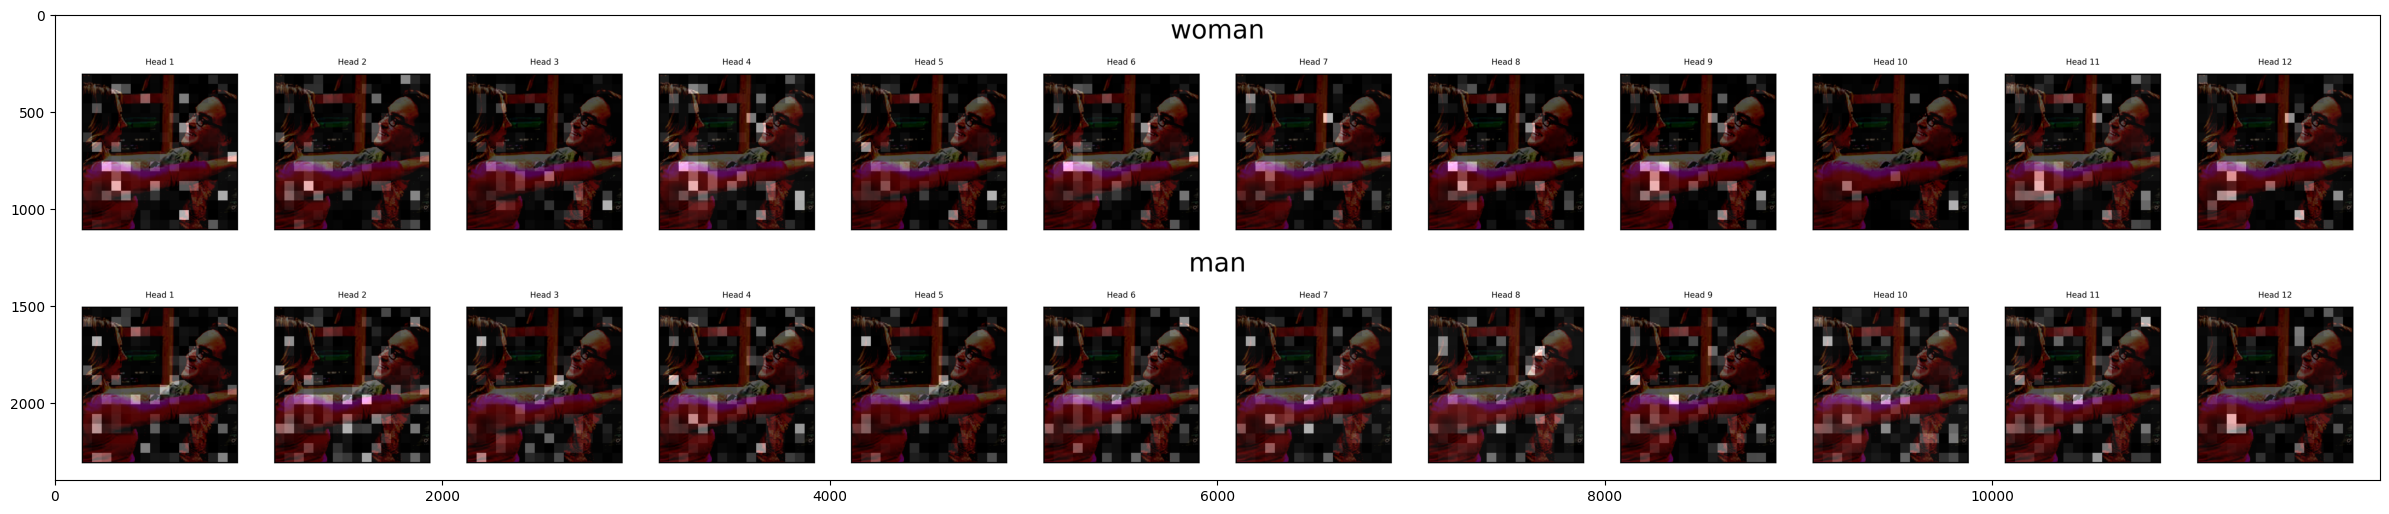

In [30]:
word_ids = [(i, word,) for i, word in enumerate(words) if word in ['man', 'woman']]
pictures = []
for i, word in word_ids:
    fig, axs = plt.subplots(1, num_heads , dpi=600, figsize=(20, 2))
    
    for head in range(num_heads):
        att = torch.zeros(num_tokens, num_tokens)
        for layer in range(num_layers):
            att += outputs.attention_masks[i][layer][0][head][:num_tokens, :num_tokens]
        att /= num_layers
        upscaled_attention = upscale_attention_weights(att[-1, :num_patches])
        plot_ax(image, upscaled_attention, f'Head {head + 1}', ax=axs[head])
    
    fig.suptitle(word, fontsize=16)
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
    plt.savefig(f'./misc/attention/head_{word}_{i}_attention.png', dpi=600)
    plt.close()
    
    pictures.append(Image.open(f'./misc/attention/head_{word}_{i}_attention.png').convert('RGB'))
    
plt.xticks([])
plt.yticks([])
joined = np.vstack([np.array(p) for p in pictures])
plt.imsave('./misc/attention/head_attention.png', joined)
plt.close()
fig = plt.figure(figsize=(30, 20))
plt.imshow(Image.open('./misc/attention/head_attention.png').convert('RGB'))

### Conclusion For Head Attention

Again, the pattern is visible, but not enough to be used in the See and Tell. For example, in Head 8 for the man word and Head 9 for the woman there is a lot of highlights on bodies, but for other heads it is not always the case. Which head to choose is completely unclear.

# Conclusion

To conclude the experiment, the upscaled attention weights appeared to not very useful for the task of matching words to the characters in the image. The reason for that is the following. Before being attended, image tokens undergo a series of transformations. The attention weights are computed after convolutional operations, positional encodings and normalization are applied. Despite image patches are still related to a specific part of the image, the amount of transformations performed dramatically shifts them from the original image. This leads to the fact that the attention weights are not very useful for the task of matching words to the characters in the image. However, the attention weights might be used without upscaling, but rather matching the image patches to the characters in the image. This approach is not explored in the `PatchCharacterAttentionExperiment.ipynb`.